## Simulation Demonstration

In [27]:
import os, shutil, sys
import h5py
import matplotlib.pyplot as plt
import numpy as np
from extra_geom import AGIPD_1MGeometry
import arrow

In [62]:
from SimEx.Calculators.AbstractPhotonDiffractor import AbstractPhotonDiffractor
from SimEx.Calculators.CrystFELPhotonDiffractor import CrystFELPhotonDiffractor
from SimEx.Parameters.CrystFELPhotonDiffractorParameters import CrystFELPhotonDiffractorParameters
from SimEx.Parameters.PhotonBeamParameters import PhotonBeamParameters
from SimEx.Parameters.DetectorGeometry import DetectorGeometry, DetectorPanel
from SimEx.Utilities.Units import electronvolt, joule, meter, radian, second

In [29]:
SimExBin = ':/gpfs/exfel/data/user/juncheng/miniconda3/envs/simex0.5/bin/'
os.environ["PATH"] += SimExBin

## Data path setup

In [30]:
data_path = './diffr'

Clean up any data from a previous run:

In [31]:
# if os.path.isdir(data_path):
#     shutil.rmtree(data_path)

# if os.path.isfile(data_path + '.h5'):
#     os.remove(data_path + '.h5')

## Set up X-ray Beam Parameters

In [32]:
beamParam = PhotonBeamParameters(
    photon_energy = 4972.0 * electronvolt,  # photon energy in eV
    beam_diameter_fwhm=130e-9 * meter,      # focus diameter in m
    pulse_energy=45e-3 * joule,             # pulse energy in J
    photon_energy_relative_bandwidth=0.003, # relative bandwidth dE/E
    divergence=0.0 * radian,                # Beam divergence in rad
    photon_energy_spectrum_type='tophat',   # Spectrum type. Acceptable values are "tophat", "SASE", and "twocolor")
)

## Detector Setting

In [33]:
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
    (-525, 625),
    (-550, -10),
    (520, -160),
    (542.5, 475),
])

<AxesSubplot:title={'center':'AGIPD-1M detector geometry (No file)'}, xlabel='pixels', ylabel='pixels'>

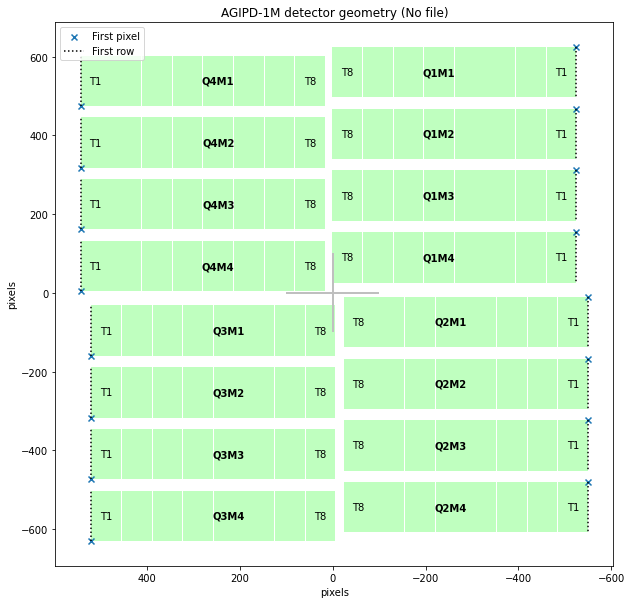

In [34]:
geom.inspect()

In [35]:
geom_file = 'agipd_simple_2d.geom'
geom.write_crystfel_geom(
    geom_file,
    dims=('frame', 'ss', 'fs'),
    adu_per_ev=1.0,
    clen=0.13,          # Sample - detector distance in m
    photon_energy=4972, # eV
    data_path='/data/data',
)

## Diffractor Settings

In [36]:
diffParam = CrystFELPhotonDiffractorParameters(
    sample='3WUL.pdb',                    # Looks up pdb file in cwd, if not found, queries from RCSB pdb mirror.
    uniform_rotation=True,                # Apply random rotation
    number_of_diffraction_patterns=100,     #
    powder=False,                         # Set xto True to create a virtual powder diffraction pattern (unested)
    intensities_file=None,                # File that contains reflection intensities. If set to none, use uniform intensity distribution
    crystal_size_range=[1e-7, 1e-7],      # Range ([min,max]) in units of metres of crystal size.
    poissonize=False,                     # Set to True to add Poisson noise.
    number_of_background_photons=0,       # Change number to add uniformly distributed background photons.
    suppress_fringes=False,               # Set to True to suppress side maxima between reflection peaks.
    beam_parameters=beamParam,            # Beam parameters object from above
    detector_geometry=geom_file,          # External file that contains the detector geometry in CrystFEL notation.
)

In [38]:
diffractor = CrystFELPhotonDiffractor(
    parameters=diffParam, output_path=data_path
)

## Run the simulation

In [ ]:
# from timeit import default_timer as timer
# start = timer()

# status = diffractor.backengine()

# end = timer()
# print(end - start,'s') # Time in seconds
# if (status == 0):
#     print ("Successful!")
# else:
#     print ("Error code:",status)

In [ ]:
# diffractor.saveH5()

In [24]:
class startTime:
    def __init__(self):
        self.arw = arrow.now()
    def getTimeEstimated(self, hours, minutes=0):
        arw = self.arw
        end_time_estimated = arw.shift(hours=hours,minutes=minutes)
        return end_time_estimated.isoformat()
    def getStartTime(self):
        return self.arw.isoformat()

In [65]:
hours_estimated = 1
detector_name = 'AGIPD'
# 1.13 MHz, ref: http://www.nature.com/articles/s41592-019-0628-z
pulse_length = 30e-15 * second # fs
total_pulse_per_train = 176
# 4.5 MHz
# pulse_per_train = 2700
total_trains_per_second = 10

nexus_metas={}
ST = startTime()
start_time = ST.getStartTime()
end_time_estimated = ST.getTimeEstimated(hours = hours_estimated)
total_flux = beamParam.pulse_energy.to('eV')/beamParam.photon_energy*total_pulse_per_train*total_trains_per_second

nexus_metas['start_time'] = start_time
nexus_metas['end_time_estimated'] = end_time_estimated
nexus_metas['definition'] = 'NXmx'
nexus_metas['SAMPLE'] = {}
nexus_metas['SAMPLE']['name'] = diffParam.sample
nexus_metas['SAMPLE']['depends_on'] = '.'
nexus_metas['INSTRUMENT'] = {}
nexus_metas['INSTRUMENT']['name'] = type(diffractor).__name__
nexus_metas['DETECTOR'] = {}
nexus_metas['DETECTOR']['sensor_material'] = 'ideal'
nexus_metas['DETECTOR']['sensor_thickness'] = 0
nexus_metas['BEAM'] = {}
nexus_metas['BEAM']['incident_wavelength'] = 12.398/beamParam.photon_energy.to('keV').magnitude
nexus_metas['BEAM']['total_flux'] = total_flux.magnitude #photons/second
nexus_metas['BEAM']['total_flux'] = total_flux.magnitude #photons/second
nexus_metas['SOURCE'] = {}
nexus_metas['SOURCE']['name'] = "SIMEX"



for key, value in nexus_metas.items():
    print(f'{key}: {value}')

start_time: 2021-04-09T16:16:11.763493+02:00
end_time_estimated: 2021-04-09T17:16:11.763493+02:00
definition: NXmx
SAMPLE: {'name': '3WUL.pdb', 'depends_on': '.'}
INSTRUMENT: {'name': 'CrystFELPhotonDiffractor'}
DETECTOR: {'sensor_material': 'ideal', 'sensor_thickness': 0}
BEAM: {'incident_wavelength': 2.4935639581657276, 'total_flux': 9.942226844273782e+16}
SOURCE: {'name': 'SIMEX'}


In [ ]:
# SOURCE:
# 	name: SIMEX


This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No. 823852.